In [1]:
from datetime import datetime

In [2]:
from calculator.calculator import MetricCalculator

In [3]:
calc = MetricCalculator('datasets/visits_info_short.csv', 'datasets/orders_info_short.csv', 'datasets/costs_info_short.csv')

In [4]:
calc.columns_fixer()

In [5]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 30

In [6]:
profiles = calc.get_profiles()

In [7]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [8]:
retention_raw, retention_grouped, retention_hist = calc.get_retention(profiles, observation_date, horizon_days)

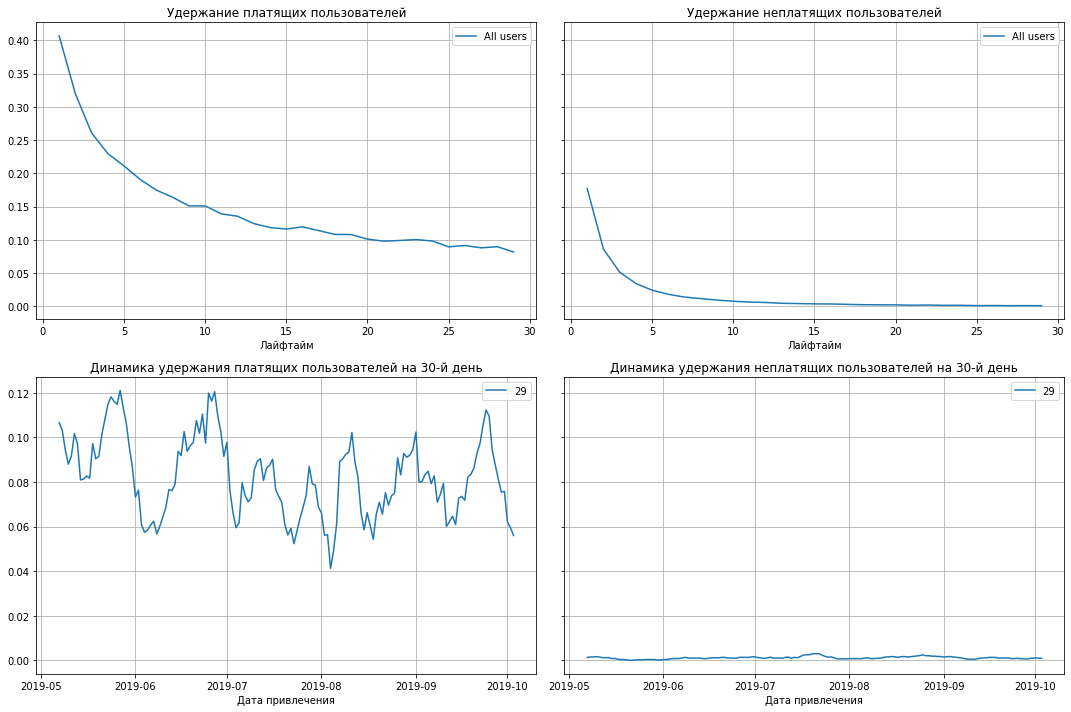

In [9]:
calc.plot_retention(retention_grouped, retention_hist, horizon_days)

In [10]:
cr_raw, cr_grouped, cr_hist = calc.get_conversion(profiles, observation_date, horizon_days)

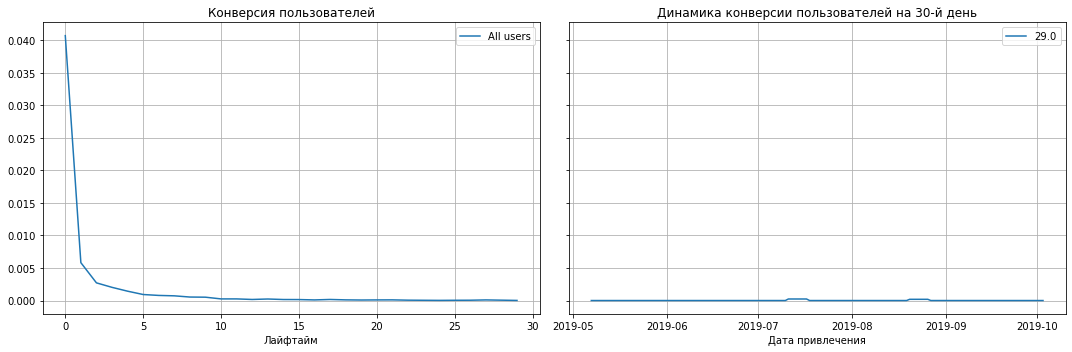

In [11]:
calc.plot_conversion(cr_grouped, cr_hist, horizon_days)

In [12]:
ltv_raw, ltv_grouped, ltv_hist, roi_grouped, roi_hist = calc.get_ltv(profiles, observation_date, horizon_days)

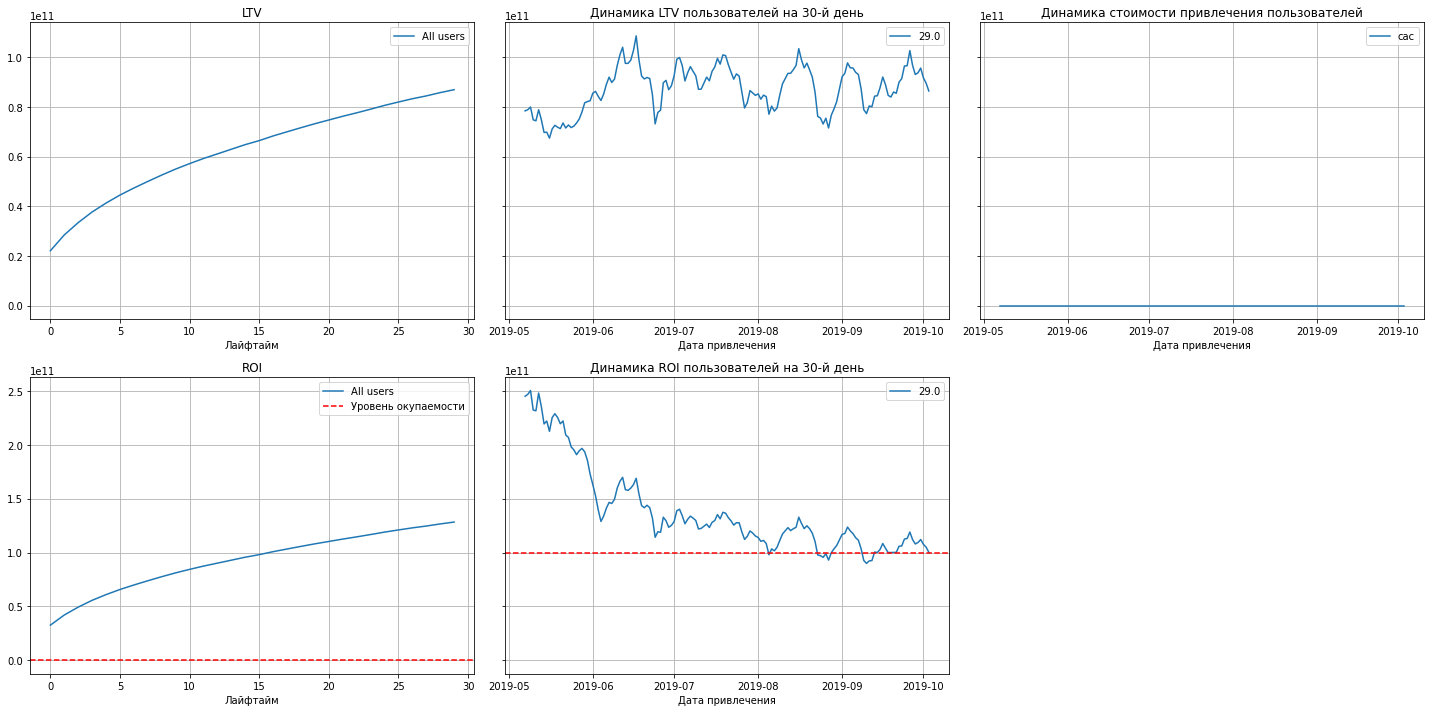

In [13]:
calc.plot_ltv_roi(ltv_grouped, ltv_hist, roi_grouped, roi_hist, horizon_days) 

In [14]:
ltv_raw, ltv_grouped, ltv_hist, roi_grouped, roi_hist = calc.get_ltv(profiles, observation_date, horizon_days, dimensions=['region'])

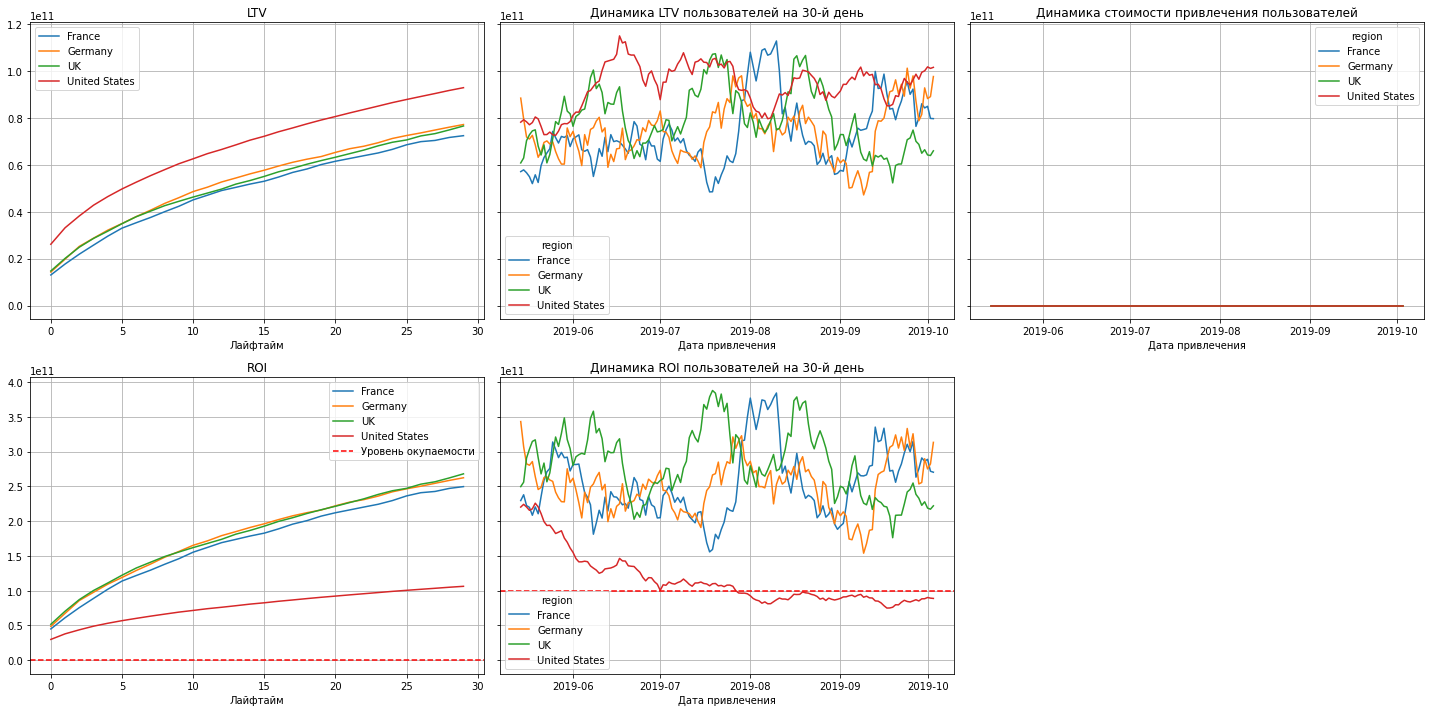

In [15]:
calc.plot_ltv_roi(ltv_grouped, ltv_hist, roi_grouped, roi_hist, horizon_days, window=14) 

In [16]:
ltv_raw, ltv_grouped, ltv_hist, roi_grouped, roi_hist = calc.get_ltv(profiles, observation_date, horizon_days, dimensions=['channel'])

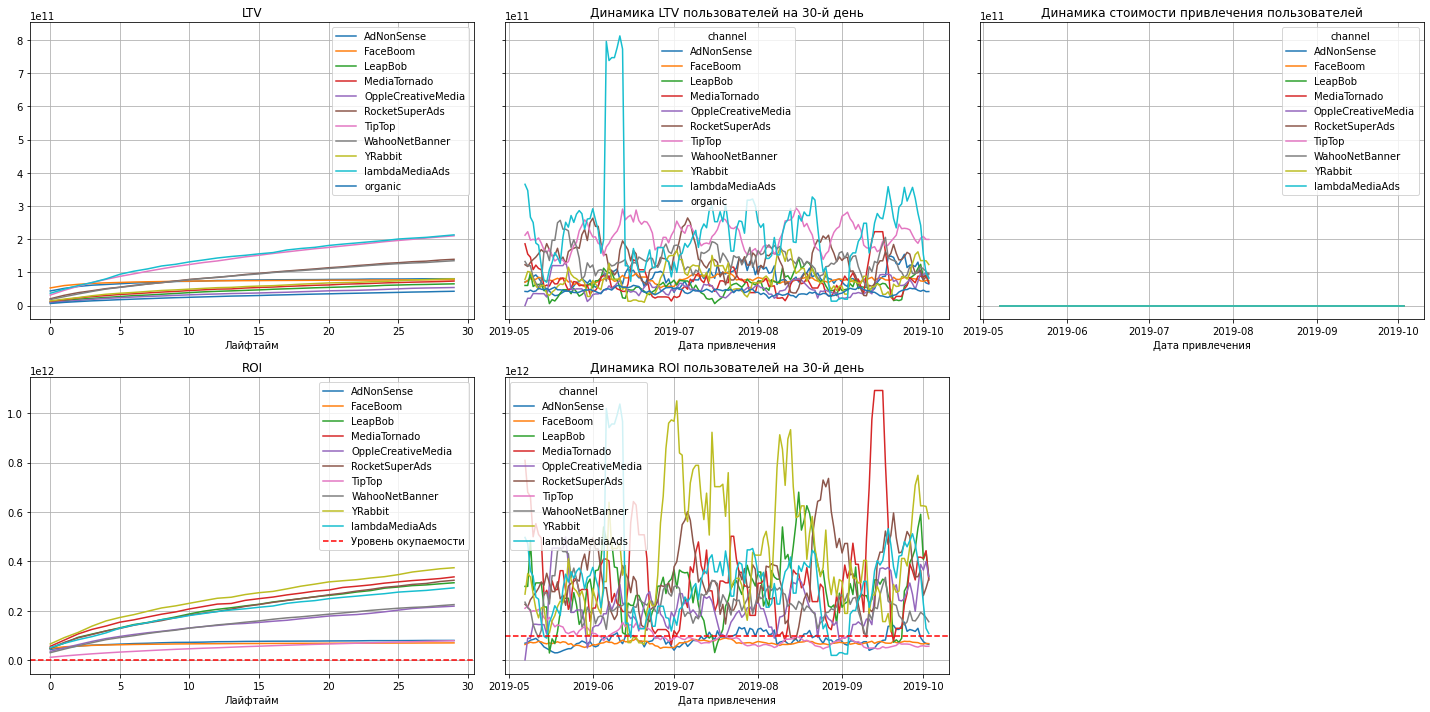

In [17]:
calc.plot_ltv_roi(ltv_grouped, ltv_hist, roi_grouped, roi_hist, horizon_days) 

In [18]:
ltv_raw, ltv_grouped, ltv_hist, roi_grouped, roi_hist = calc.get_ltv(profiles, observation_date, horizon_days, dimensions=['payer'])

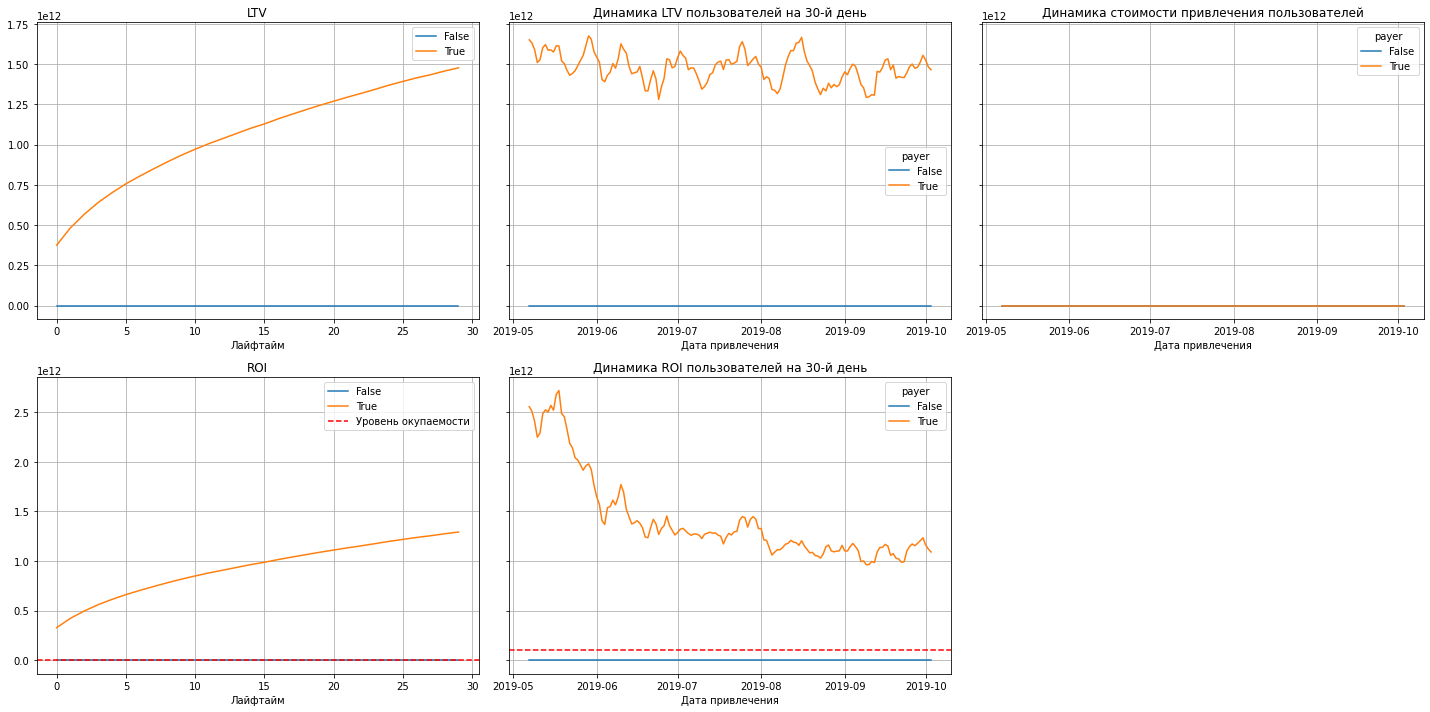

In [19]:
calc.plot_ltv_roi(ltv_grouped, ltv_hist, roi_grouped, roi_hist, horizon_days) 

In [20]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [21]:
roi_hist

cohort_size       cac           0.0           1.0  \
payer dt                                                              
False 2019-05-01          868  0.318454  0.000000e+00  0.000000e+00   
      2019-05-02          728  0.293057  0.000000e+00  0.000000e+00   
      2019-05-03          807  0.293298  0.000000e+00  0.000000e+00   
      2019-05-04          960  0.309096  0.000000e+00  0.000000e+00   
      2019-05-05          935  0.318656  0.000000e+00  0.000000e+00   
...                       ...       ...           ...           ...   
True  2019-09-29           84  1.610421  2.861448e+11  3.755425e+11   
      2019-09-30           74  1.300061  2.896652e+11  3.739688e+11   
      2019-10-01           48  1.286790  2.922109e+11  3.884819e+11   
      2019-10-02           57  1.405186  2.597496e+11  3.076798e+11   
      2019-10-03           73  1.476760  2.686771e+11  3.460357e+11   

                           2.0           3.0           4.0           5.0  \
payer dt                                                                   
False 2019-05-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-05-02  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-05-03  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-05-04  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-05-05  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...                        ...           ...           ...           ...   
True  2019-09-29  4.308995e+11  5.044940e+11  5.293378e+11  5.627161e+11   
      2019-09-30  4.344300e+11  4.915452e+11  5.549938e+11  6.244295e+11   
      2019-10-01  4.531014e+11  4.884991e+11  5.335232e+11  5.725720e+11   
      2019-10-02  3.437396e+11  4.008254e+11  4.187330e+11  4.412331e+11   
      2019-10-03  4.110984e+11  4.575071e+11  5.027176e+11  5.455048e+11   

                           6.0           7.0  ...          20.0          21.0  \
payer dt                                      ...                               
False 2019-05-01  0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
      2019-05-02  0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
      2019-05-03  0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
      2019-05-04  0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
      2019-05-05  0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
...                        ...           ...  ...           ...           ...   
True  2019-09-29  5.753437e+11  6.076870e+11  ...  9.435999e+11  9.503414e+11   
      2019-09-30  6.764077e+11  7.061063e+11  ...  1.074435e+12  1.089297e+12   
      2019-10-01  6.255180e+11  6.699139e+11  ...  1.058921e+12  1.072307e+12   
      2019-10-02  4.719616e+11  4.977074e+11  ...  7.445304e+11  7.445304e+11   
      2019-10-03  5.635039e+11  5.984009e+11  ...  8.237411e+11  8.433293e+11   

                          22.0          23.0          24.0          25.0  \
payer dt                                                                   
False 2019-05-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-05-02  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-05-03  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-05-04  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      2019-05-05  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...                        ...           ...           ...           ...   
True  2019-09-29  9.635386e+11  9.740607e+11  9.795080e+11  9.933635e+11   
      2019-09-30  1.103814e+12  1.128200e+12  1.149913e+12  1.167110e+12   
      2019-10-01  1.072307e+12  1.076782e+12  1.104998e+12  1.107763e+12   
      2019-10-02  7.448479e+11  7.629644e+11  7.629644e+11  7.727262e+11   
      2019-10-03  8.625262e+11  8.735658e+11  8.926748e+11  9.172241e+11   

                          26.0          27.0          28.0    

In [22]:
cac_hist = roi_hist[['cac']]

In [23]:
columns = [name for name in cac_hist.index.names if name not in ['dt']]

In [24]:
filtered_data = cac_hist.pivot_table(index='dt', columns=columns, values='cac', aggfunc='mean')

In [25]:
filtered_data

payer,False,True
dt,,
2019-05-01,0.318454,0.692739
2019-05-02,0.293057,0.583317
2019-05-03,0.293298,0.628053
2019-05-04,0.309096,0.732147
2019-05-05,0.318656,0.627482
...,...,...
2019-09-29,0.802152,1.610421
2019-09-30,0.822800,1.300061
2019-10-01,0.826083,1.286790


In [26]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

<AxesSubplot:xlabel='dt'>

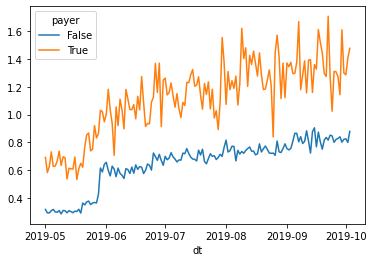

In [27]:
filtered_data.plot()

In [28]:
from matplotlib import pyplot as plt

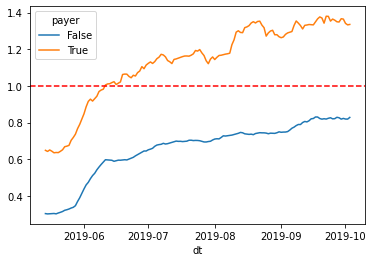

In [29]:
filter_data(filtered_data, 14).plot()
plt.axhline(y=1, color='red', linestyle='--',
            label='Уровень окупаемости')

In [30]:
roi_grouped

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0
payer,,,,,,,,,,,,,,,,,,,,,
False,121310,0.648370,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
True,7585,1.143258,3.285694e+11,4.233409e+11,4.969495e+11,5.605679e+11,6.138163e+11,6.617388e+11,7.038491e+11,7.432153e+11,...,1.110609e+12,1.132794e+12,1.153488e+12,1.175276e+12,1.197948e+12,1.218068e+12,1.237712e+12,1.254653e+12,1.274340e+12,1.291897e+12
